# PySpark

In [1]:
import findspark
findspark.init() 

from pyspark.sql import SparkSession

spark=SparkSession.builder.appName('Nombre').getOrCreate()

path='../datasets/student-por.csv'

data=spark.read.csv(path, header=True, inferSchema=True, sep=';')

data.show(5)

+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|    GP|  F| 17|      U|    GT3|      T|

In [2]:
drop_cols=['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']

data=data.select([c for c in data.columns if c not in drop_cols])

data

DataFrame[address: string, famsize: string, Pstatus: string, Medu: int, Fedu: int, traveltime: int, studytime: int, failures: int, schoolsup: string, famsup: string, paid: string, activities: string, nursery: string, higher: string, internet: string, romantic: string, famrel: int, freetime: int, goout: int, Dalc: int, Walc: int, health: int, absences: int, G1: int, G2: int, G3: int]

In [3]:
non_numeric_columns=[item[0]for item in data.dtypes if item[1].startswith('string')]
non_numeric_columns

['address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [4]:
struct_data=data.select('*')
struct_data

DataFrame[address: string, famsize: string, Pstatus: string, Medu: int, Fedu: int, traveltime: int, studytime: int, failures: int, schoolsup: string, famsup: string, paid: string, activities: string, nursery: string, higher: string, internet: string, romantic: string, famrel: int, freetime: int, goout: int, Dalc: int, Walc: int, health: int, absences: int, G1: int, G2: int, G3: int]

In [5]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType


indexers=StringIndexer(inputCols=non_numeric_columns, 
                       outputCols=[c+'_' for c in non_numeric_columns],
                       stringOrderType='alphabetAsc')

struct_data=indexers.fit(struct_data).transform(struct_data)

struct_data=struct_data.select([c for c in struct_data.columns if c not in non_numeric_columns])

for c in struct_data.columns:
    struct_data=struct_data.withColumn(c, struct_data[c].cast(IntegerType()))

    
struct_data.toPandas()

,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,...,nursery_,famsize_,internet_,higher_,activities_,famsup_,address_,romantic_,Pstatus_,schoolsup_
0,4,4,2,2,0,4,3,4,1,1,...,1,0,0,1,0,0,1,0,0,1
1,1,1,1,2,0,5,3,3,1,1,...,0,0,1,1,0,1,1,0,1,0
2,1,1,1,2,0,4,3,2,2,3,...,1,1,1,1,0,0,1,0,1,1
3,4,2,1,3,0,3,2,2,1,1,...,1,0,1,1,1,1,1,1,1,0
4,3,3,1,2,0,4,3,2,1,2,...,1,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2,3,1,3,1,5,4,2,1,2,...,0,0,1,1,1,0,0,0,1,0
645,3,1,1,2,0,4,3,4,1,1,...,1,1,1,1,0,1,1,0,1,0
646,1,1,2,2,0,1,1,1,1,1,...,1,0,0,1,1,0,1,0,1,0
647,3,1,2,1,0,2,4,5,3,4,...,0,1,1,1,0,0,1,0,1,0


# Multiprocessing

In [6]:
def square(x):
    return x**2

In [7]:
data=[i for i in range(1000000)]

In [8]:
%%time
seq=[square(x) for x in data]
seq[:10]

CPU times: user 335 ms, sys: 17.5 ms, total: 352 ms
Wall time: 353 ms


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [9]:
import multiprocessing as mp
import numpy as np

In [10]:
mp.cpu_count()

4

In [11]:
%%time
pool=mp.Pool(mp.cpu_count())   # grupo con todos los nucleos

res=pool.map(square, data)
pool.close()
res[:10]

CPU times: user 130 ms, sys: 64.6 ms, total: 194 ms
Wall time: 415 ms


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [12]:
res=[]
for e in data:
    res.append(e**2)
res[:10]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [13]:
list(map(square, data))[:10]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [14]:
array=np.random.randint(0, 10, size=[200, 5000])
data=array.tolist()

In [15]:
def rango(r, mini, maxi):
    c=0
    for e in r:
        if mini<=e<=maxi:
            c=+1
    return c

In [16]:
%time res=[rango(e, 4, 8) for e in data]
res[:10]

CPU times: user 67.5 ms, sys: 4.88 ms, total: 72.4 ms
Wall time: 71.8 ms


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
pool=mp.Pool()

%time res=pool.map(rango, [rango(e, 4, 8) for e in data])
pool.close()

TypeError: rango() missing 2 required positional arguments: 'mini' and 'maxi'

In [18]:
def rango2(i, r, mini, maxi):
    c=0
    
    for e in r:
        if mini<=e<=maxi:
            c=+1
            
    return i, c

In [19]:
res=[]

def colecta(resul):
    global res
    res.append(resul)

In [20]:
pool=mp.Pool(3)

for i,e in enumerate(data):
    pool.apply_async(rango2, args=(i,e,4,8), callback=colecta)
    
pool.close()
pool.join()

res.sort(key=lambda x: x[0])

res[:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [21]:
import pandas as pd

In [22]:
df=pd.DataFrame(np.random.randint(3, 10, size=[5, 2]))
df

,0,1
0,6,4
1,3,5
2,3,3
3,5,7
4,6,7


In [23]:
def hipo(c):
    return (c[1]**2+c[2]**2)**0.5

In [24]:
with mp.Pool(3) as pool:
    res=pool.imap(hipo, df.itertuples(name=None), chunksize=10)
    out=[round(e, 2) for e in res]
out

[7.21, 5.83, 4.24, 8.6, 9.22]

# Pathos

In [25]:
from pathos.multiprocessing import ProcessingPool as Pool

In [26]:
df

,0,1
0,6,4
1,3,5
2,3,3
3,5,7
4,6,7


In [27]:
def fun(df):
    return df.shape

In [28]:
cores=mp.cpu_count()

df_split=np.array_split(df, cores, axis=0)

pool=Pool(cores)

df_out=pd.DataFrame(np.vstack(pool.map(fun, df_split)))

pool.close()
pool.join()
pool.clear()

In [29]:
df_out

,0,1
0,2,2
1,1,2
2,1,2
3,1,2


# Dask

In [30]:
# !pip3 install "dask[complete]"
# !pip3 install dask_ml

In [31]:
import os
import dask
import dask.dataframe as dd

In [32]:
archivos=os.path.join('../datasets', 'accounts.*.csv')
print(archivos)

../datasets/accounts.*.csv


In [33]:
df=dd.read_csv(archivos)
df.head()

,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [34]:
df=dd.read_csv(os.path.join('../datasets', 'nycflights', '*.csv'),
               parse_dates={'Date':[0,1,2]})
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [35]:
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In [37]:
df=dd.read_csv(os.path.join('../datasets', 'nycflights', '*.csv'),
               parse_dates={'Date':[0,1,2]},
               dtype={'TailNum': str, 'CRSElapsedTime':float, 'Cancelled':bool})


df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [38]:
df.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 21 entries, Date to Diverted
dtypes: datetime64[ns](1), object(4), bool(1), float64(10), int64(5)
memory usage: 401.0 MB


In [39]:
df.shape

(Delayed('int-e94f44da-93a1-456b-b58d-ef63dcaf3514'), 21)

In [40]:
df.DepDelay.max().compute()

1435.0

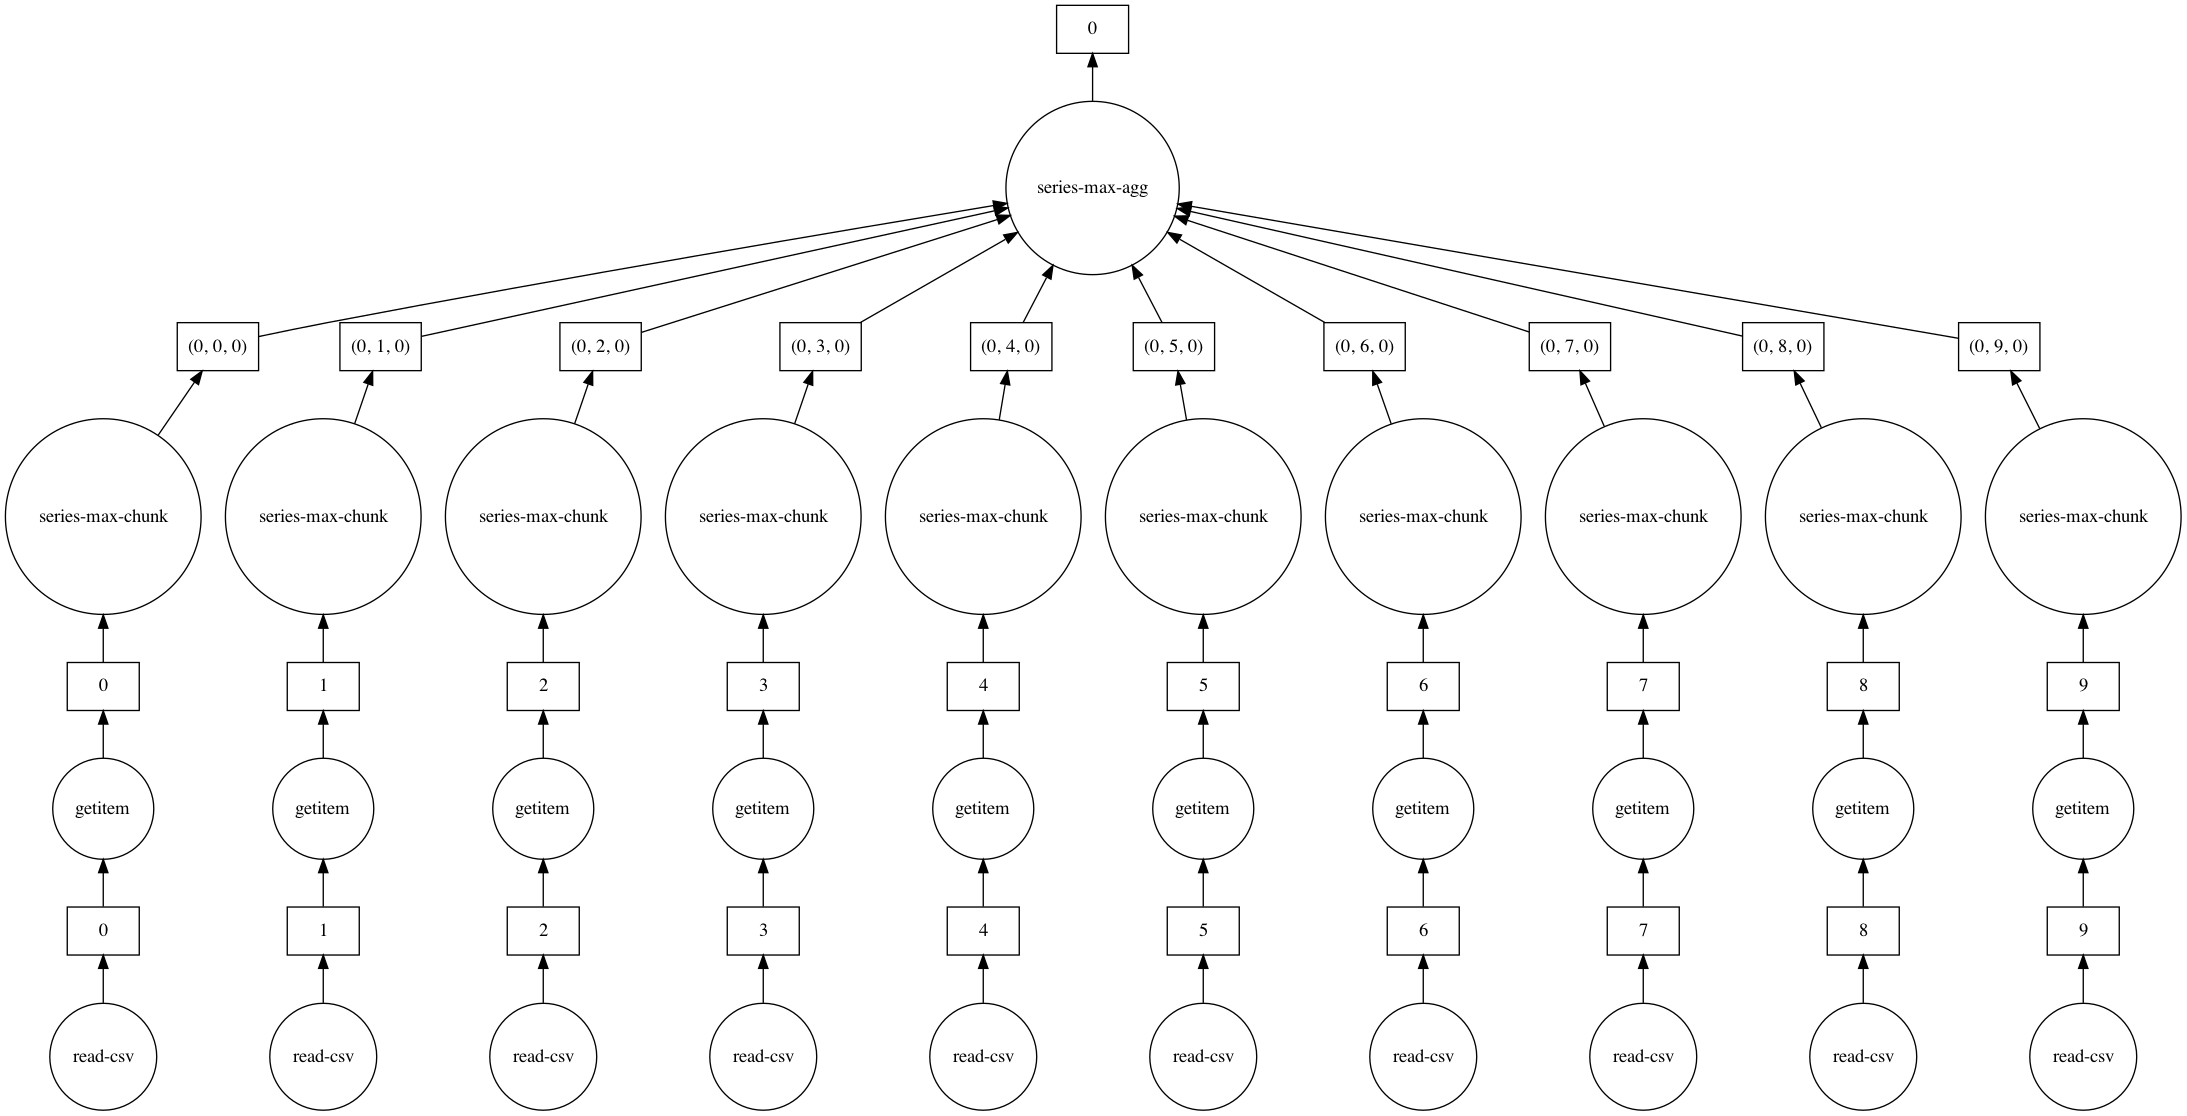

In [41]:
df.DepDelay.max().visualize(filename='../images/max_dask.png')

In [42]:
len(df)

2611892

In [43]:
len(df[~df.Cancelled])    # virgulilla ==> lo contrario (como el no logico)

2540961

In [44]:
df.groupby('Origin').DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [45]:
no_cancelado=df[~df.Cancelled]

media_delay=no_cancelado.DepDelay.mean()
std_delay=no_cancelado.DepDelay.std()

In [46]:
std_delay

dd.Scalar<series-..., dtype=float64>

In [47]:
%time media_delay.compute()

CPU times: user 6.16 s, sys: 1.35 s, total: 7.51 s
Wall time: 4.3 s


9.206602541321965

In [48]:
%time std_delay.compute()

CPU times: user 6.18 s, sys: 1.33 s, total: 7.51 s
Wall time: 4.37 s


28.974539774551456

In [49]:
%time media_delay_res, std_delay_res = dask.compute(media_delay, std_delay)

CPU times: user 6.16 s, sys: 1.31 s, total: 7.47 s
Wall time: 4.19 s


In [50]:
media_delay_res

9.206602541321965

In [51]:
std_delay_res

28.974539774551456

In [52]:
type(std_delay_res)

numpy.float64

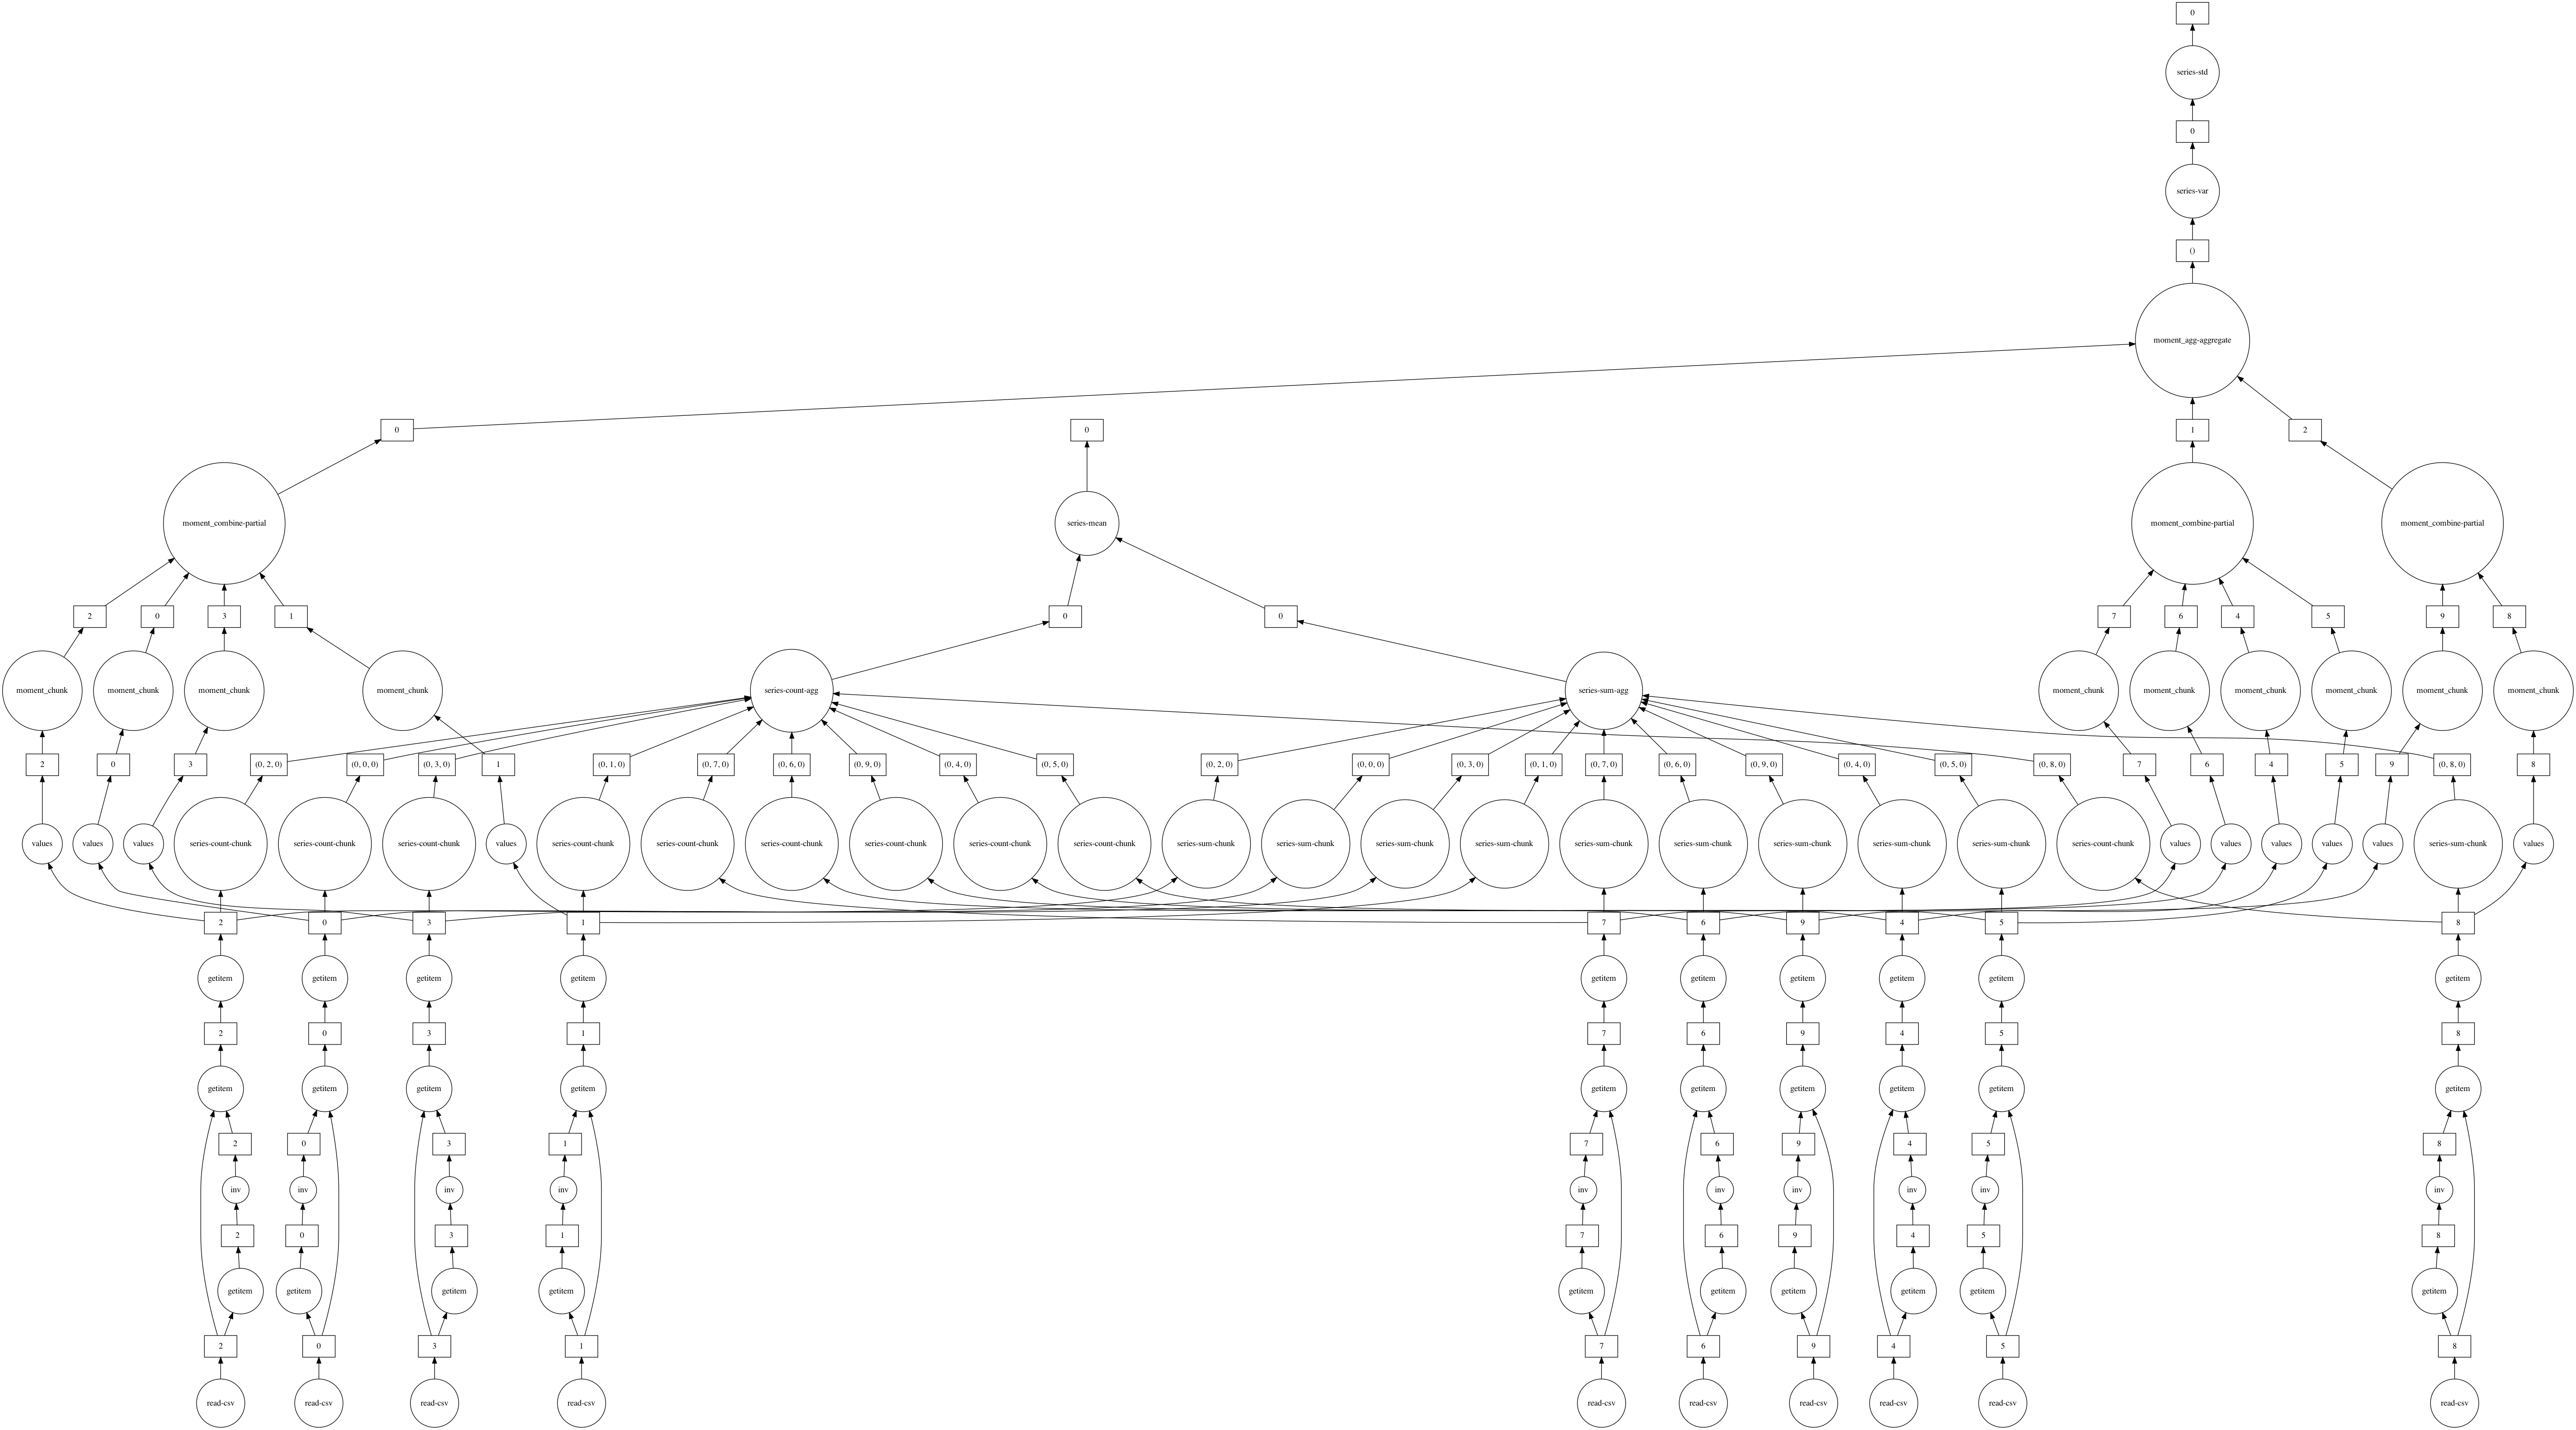

In [53]:
dask.visualize(media_delay, std_delay, filename='../images/std_dask.png')

# HDFS y Parquet  (sistemas de archivos)

In [54]:
%time df_csv=dd.read_csv(archivos)
df_csv.head()

CPU times: user 11.5 ms, sys: 5.64 ms, total: 17.1 ms
Wall time: 16.7 ms


,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [55]:
target=os.path.join('../datasets', 'accounts.h5')

In [ ]:
%time df_csv.to_hdf(target, key='../datasets')

In [ ]:
%time df_h=dd.read_hdf(target, key='../datasets')
df_h.head()

In [ ]:
df_h.info(memory_usage='deep')

In [ ]:
%time df_h.amount.sum().compute()

In [ ]:
# parquet
# !pip3 install fastparquet

In [ ]:
target=os.path.join('../datasets', 'accounts.parquet')

df_csv.categorize(columns=['names']).to_parquet(target,
                                                storage_options={'has_nulls':True},
                                                engine='fastparquet')

In [ ]:
%time df_p=dd.read_parquet(target)
df_p.head()

In [ ]:
df_csv.info(memory_usage='deep')

In [ ]:
df_p.info(memory_usage='deep')

In [ ]:
%time df_csv.amount.sum().compute()

In [ ]:
%time df_p.amount.sum().compute()

# tqdm

In [ ]:
# !pip3 install tqdm

In [ ]:
from tqdm import trange

In [ ]:
import time
from tqdm.notebook import tqdm

In [ ]:
for i in tqdm(range(2), desc='Primer loop'):
    tqdm._instances.clear()
    for j in tqdm(range(5), desc='Segundo loop'):
        time.sleep(.5)

In [ ]:
for i in trange(2):
    tqdm._instances.clear()
    for j in trange(5):
        time.sleep(.5)

In [ ]:
df=pd.DataFrame(np.random.randint(0, int(1e8), (10000, 1000)))
df.head()

In [ ]:
tqdm.pandas()

df.groupby(0).progress_apply(lambda x: x**2)

In [ ]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar

In [ ]:
res=[]

def fun(x):
    time.sleep(x)
    return x

for i in trange(10):
    res.append(delayed(fun)(i))
    
with ProgressBar():
    compute(res)

In [ ]:
res[5].compute()

# Vaex

https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94

**Data:** https://vaex.io/docs/datasets.html

**si no plotea...:** https://stackoverflow.com/questions/57323126/how-to-do-interactive-2d-scatter-plot-zoom-point-selection-in-vaex

In [ ]:
import vaex

import numpy as np
import pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
# tamaño del archivo
!ls -l -h ../datasets/yellow_taxi_2015_f32s.hdf5

In [ ]:
%%time
# lectura archivo
df=vaex.open('../datasets/yellow_taxi_2015_f32s.hdf5')
df

In [ ]:
%%time
df.describe()

In [ ]:
%%time
df.plot_widget(df.pickup_longitude, 
               df.pickup_latitude, 
               backend='bqplot',
               shape=512, 
               limits='minmax',
               f='log1p', 
               colormap='plasma')